## Baseline

In [ ]:
!pip install transformers
!pip install torch
!pip install torchtext
!pip install datasets
!pip install torchaudio
!pip install matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fairseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11289143 sha256=8b977688896b54911cb86105297fc81c8aa1e8ff833392cb80407dc19eeb8c60
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.wh

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple, Dict
import matplotlib.pyplot as plt  # For plotting and visualization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Transformer model

In [ ]:
class TransformerEncoderExtend(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.embedding_dim = args.embedding_dim
        self.dropout = args.dropout
        self.layer_type = args.layer_type
        self.encoder_layers = args.encoder_layers
        self.attention_relax = args.attention_relax

        self.layers = nn.ModuleList([
            self.build_encoder_layer(args) for _ in range(args.encoder_layers)
        ])

    def build_encoder_layer(self, args):
        if args.layer_type == "transformer":
            if (args.deepnorm or args.subln or args.attention_relax > 0.0):
                residual_alpha = 1.0
                if args.deepnorm:
                    residual_alpha = math.pow(2.0 * args.encoder_layers, 0.25)

                layer = TransformerSentenceEncoderLayerExtend(
                    embedding_dim=self.embedding_dim,
                    ffn_embedding_dim=args.encoder_ffn_embed_dim,
                    num_attention_heads=args.encoder_attention_heads,
                    dropout=self.dropout,
                    attention_dropout=args.attention_dropout,
                    activation_dropout=args.activation_dropout,
                    activation_fn=args.activation_fn,
                    layer_norm_first=args.layer_norm_first,
                    residual_alpha=residual_alpha,
                    attention_relax=args.attention_relax,
                )
            else:
                layer = TransformerSentenceEncoderLayer(
                    embedding_dim=self.embedding_dim,
                    ffn_embedding_dim=args.encoder_ffn_embed_dim,
                    num_attention_heads=args.encoder_attention_heads,
                    dropout=self.dropout,
                    attention_dropout=args.attention_dropout,
                    activation_dropout=args.activation_dropout,
                    activation_fn=args.activation_fn,
                    layer_norm_first=args.layer_norm_first,
                )
        elif args.layer_type == "conformer":
            layer = ConformerWav2Vec2EncoderLayer(
                embed_dim=self.embedding_dim,
                ffn_embed_dim=args.encoder_ffn_embed_dim,
                attention_heads=args.encoder_attention_heads,
                dropout=args.dropout,
                depthwise_conv_kernel_size=args.depthwise_conv_kernel_size,
                activation_fn="swish",
                attn_type=args.attn_type,
                use_fp16=args.fp16,
                pos_enc_type="abs",
            )

        from fairseq.distributed import fsdp_wrap
        from fairseq.modules.checkpoint_activations import checkpoint_wrapper

        layer = fsdp_wrap(layer)
        if args.checkpoint_activations:
            layer = checkpoint_wrapper(layer)
        return layer

    def forward(
        self,
        x: torch.Tensor,
        self_attn_mask: torch.Tensor = None,
        self_attn_padding_mask: torch.Tensor = None,
        need_weights: bool = False,
        att_args=None,
    ):
        attn_weights = None
        for layer in self.layers:
            x, attn_weights_layer = layer(
                x, self_attn_mask, self_attn_padding_mask, need_weights, att_args
            )
            if attn_weights_layer is not None:
                attn_weights = attn_weights_layer

        return x, attn_weights


In [ ]:
class TransformerSentenceEncoderLayerExtend(nn.Module):
    def __init__(
        self,
        embedding_dim=768,
        ffn_embedding_dim=3072,
        num_attention_heads=8,
        dropout=0.1,
        attention_dropout=0.1,
        activation_dropout=0.1,
        activation_fn="relu",
        layer_norm_first=False,
        residual_alpha=1.0,
        subln=False,
        attention_relax=-1.0,
    ):
        super(TransformerSentenceEncoderLayerExtend, self).__init__()
        self.residual_alpha = residual_alpha
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.activation_dropout = activation_dropout

        self.activation_fn = nn.ReLU()  # Adjust activation function as needed

        if attention_relax > 0:
            self.self_attn = MultiheadAttentionExtend(
                self.embedding_dim,
                num_attention_heads,
                dropout=attention_dropout,
                attention_relax=attention_relax
            )
        else:
            self.self_attn = nn.MultiheadAttention(
                self.embedding_dim,
                num_attention_heads,
                dropout=attention_dropout
            )

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(activation_dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.layer_norm_first = layer_norm_first
        self.self_attn_layer_norm = nn.LayerNorm(self.embedding_dim)
        self.fc1 = nn.Linear(self.embedding_dim, ffn_embedding_dim)
        self.fc2 = nn.Linear(ffn_embedding_dim, self.embedding_dim)

        self.ffn_layernorm = nn.LayerNorm(ffn_embedding_dim) if subln else None
        self.final_layer_norm = nn.LayerNorm(self.embedding_dim)

    def residual_connection(self, x, residual):
        return residual * self.residual_alpha + x

    def forward(
        self,
        x: torch.Tensor,
        self_attn_mask: torch.Tensor = None,
        self_attn_padding_mask: torch.Tensor = None,
        need_weights: bool = False,
        att_args=None,
    ):
        residual = x

        if self.layer_norm_first:
            x = self.self_attn_layer_norm(x)
            x, attn = self.self_attn(
                x,
                x,
                x,
                key_padding_mask=self_attn_padding_mask,
                attn_mask=self_attn_mask,
                need_weights=False,
            )
            x = self.dropout1(x)
            x = self.residual_connection(x, residual)

            residual = x
            x = self.final_layer_norm(x)
            x = self.activation_fn(self.fc1(x))
            x = self.dropout2(x)

            if self.ffn_layernorm is not None:
                x = self.ffn_layernorm(x)

            x = self.fc2(x)
            layer_result = x
            x = self.dropout3(x)
            x = self.residual_connection(x, residual)

        else:
            x, attn = self.self_attn(
                x,
                x,
                x,
                key_padding_mask=self_attn_padding_mask,
                need_weights=False,
            )

            x = self.dropout1(x)
            x = self.residual_connection(x, residual)

            x = self.self_attn_layer_norm(x)
            residual = x
            x = self.activation_fn(self.fc1(x))
            x = self.dropout2(x)
            x = self.fc2(x)
            layer_result = x
            x = self.dropout3(x)
            x = self.residual_connection(x, residual)
            x = self.final_layer_norm(x)

        return x, (attn, layer_result)


In [ ]:
class MultiheadAttentionExtend(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim,
        num_heads,
        kdim=None,
        vdim=None,
        dropout=0.0,
        bias=True,
        add_bias_kv=False,
        add_zero_attn=False,
        self_attention=False,
        encoder_decoder_attention=False,
        q_noise=0.0,
        qn_block_size=8,
        attention_relax=-1.0,
    ):
        super(MultiheadAttentionExtend, self).__init__(
            embed_dim,
            num_heads,
            kdim=kdim,
            vdim=vdim,
            dropout=dropout,
            bias=bias,
            add_bias_kv=add_bias_kv,
            add_zero_attn=add_zero_attn,
            self_attention=self_attention,
            encoder_decoder_attention=encoder_decoder_attention,
            q_noise=q_noise,
            qn_block_size=qn_block_size,
        )
        self.attention_relax = attention_relax

    def forward(
        self,
        query: torch.Tensor,
        key: Optional[torch.Tensor],
        value: Optional[torch.Tensor],
        key_padding_mask: Optional[torch.Tensor] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[torch.Tensor]]]] = None,
        need_weights: bool = True,
        static_kv: bool = False,
        attn_mask: Optional[torch.Tensor] = None,
        before_softmax: bool = False,
        need_head_weights: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        if self.attention_relax > 0:
            attn_weights = super(MultiheadAttentionExtend, self).forward(
                query,
                key,
                value,
                key_padding_mask,
                incremental_state,
                need_weights,
                static_kv,
                attn_mask,
                before_softmax,
                need_head_weights,
            )

            attn_weights_relax = attn_weights / self.attention_relax
            attn_max_relax = torch.max(attn_weights_relax, dim=-1, keepdim=False).unsqueeze(2)
            attn_weights = (attn_weights_relax - attn_max_relax) * self.attention_relax

            attn_weights_float = F.softmax(attn_weights, dim=-1)
            attn_weights = attn_weights_float.type_as(attn_weights)
            attn_weights = self.dropout_module(attn_weights)

            if value is not None:
                output = torch.bmm(attn_weights, value)
            else:
                output = attn_weights

            if need_weights:
                attn_weights = attn_weights_float

            return output, attn_weights
        else:
            return super(MultiheadAttentionExtend, self).forward(
                query,
                key,
                value,
                key_padding_mask,
                incremental_state,
                need_weights,
                static_kv,
                attn_mask,
                before_softmax,
                need_head_weights,
            )



In [ ]:
class MERTConfigClass:
    def __init__(self, num_layers=3, dropout_rate=0.5, learning_rate=1e-3):
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.embedding_dim = 768
        self.encoder_ffn_embed_dim = 3072
        self.encoder_attention_heads = 8
        self.dropout = 0.1
        self.attention_dropout = 0.1
        self.activation_dropout = 0.1
        self.activation_fn = "relu"
        self.layer_norm_first = False
        self.attention_relax = -1.0  # Set to a positive value to enable attention relaxation
        self.encoder_layers = 6  # Number of encoder layers
        self.deepnorm = False
        self.layer_type = "transformer"  # or "conformer"
        self.subln = True
        self.checkpoint_activations = False


In [ ]:
# Usage example:
args = MERTConfigClass()  # Replace with your MERT configuration
model = TransformerEncoderExtend(args)
input_tensor = torch.randn((10, 32, 768))  # Replace with your input shape
output, attn_weights = model(input_tensor)


In [ ]:
print(output,attn_weights)

tensor([[[ 0.7063, -0.5825,  1.0235,  ..., -0.5285, -0.8831,  0.6301],
         [ 0.6254, -1.8232, -0.3116,  ...,  0.1921, -0.2620,  0.8823],
         [-0.5097, -1.7459,  0.5401,  ...,  0.8026, -0.0442, -0.7036],
         ...,
         [-0.1847, -1.1339,  2.1444,  ...,  0.6364, -0.0562,  0.2216],
         [-0.8374, -0.1698, -1.1708,  ..., -1.2239,  0.3996,  1.5773],
         [-0.2338, -0.9984,  0.8334,  ...,  0.5907, -2.5755, -0.0721]],

        [[ 0.7980, -1.0198,  0.3502,  ...,  0.5785, -0.5473, -0.5298],
         [ 0.7646, -2.1319,  0.5169,  ...,  1.1951,  0.5386, -0.7525],
         [ 0.1597,  0.1289, -0.1329,  ...,  0.4248, -1.3008, -2.2555],
         ...,
         [-1.0197, -0.7744,  1.1078,  ..., -1.6701,  1.3925, -0.3175],
         [ 0.5469, -0.7342,  0.7444,  ..., -0.6361, -1.5979, -0.9737],
         [-0.2164, -0.0649, -1.2592,  ..., -0.3272, -0.5814, -1.0287]],

        [[ 1.2948,  0.6188, -1.2531,  ...,  0.0682, -1.6738,  1.6937],
         [ 1.0290, -1.2671, -0.0276,  ...,  1

## Preprocessing

In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=847fd8f3b749c0b6f9abf38dd37cf437b7ec4b62c1a0549a8652062668784562
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [ ]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = pd.read_csv('/content/drive/MyDrive/MERT_Project/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
genres = pd.read_csv('/content/drive/MyDrive/MERT_Project/fma_metadata/genres.csv', index_col=0)
features = pd.read_csv('/content/drive/MyDrive/MERT_Project/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
echonest = pd.read_csv('/content/drive/MyDrive/MERT_Project/fma_metadata/echonest.csv', index_col=0, header=[0, 1, 2])

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [ ]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())


,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
10,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN
20,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(106574, 52)

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [ ]:
genres.sort_values('#tracks').head(10)


,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


In [ ]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


In [ ]:
print(echonest.columns)


MultiIndex([('echonest',    'audio_features',     'acousticness'),
            ('echonest',    'audio_features',     'danceability'),
            ('echonest',    'audio_features',           'energy'),
            ('echonest',    'audio_features', 'instrumentalness'),
            ('echonest',    'audio_features',         'liveness'),
            ('echonest',    'audio_features',      'speechiness'),
            ('echonest',    'audio_features',            'tempo'),
            ('echonest',    'audio_features',          'valence'),
            ('echonest',          'metadata',       'album_date'),
            ('echonest',          'metadata',       'album_name'),
            ...
            ('echonest', 'temporal_features',              '214'),
            ('echonest', 'temporal_features',              '215'),
            ('echonest', 'temporal_features',              '216'),
            ('echonest', 'temporal_features',              '217'),
            ('echonest', 'temporal_features', 

In [ ]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())


249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


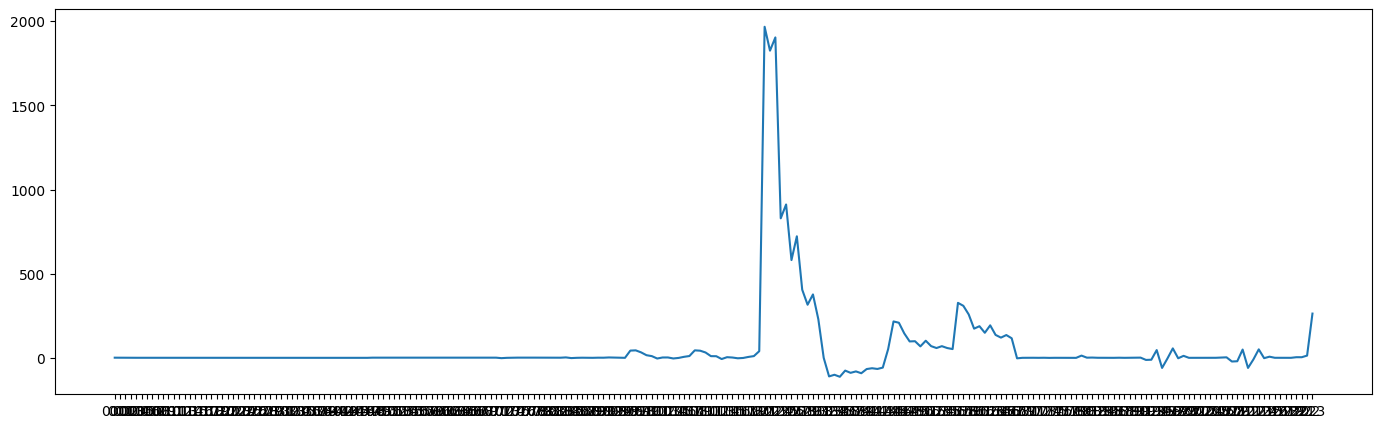

In [ ]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

((5631, 2), (5631,))

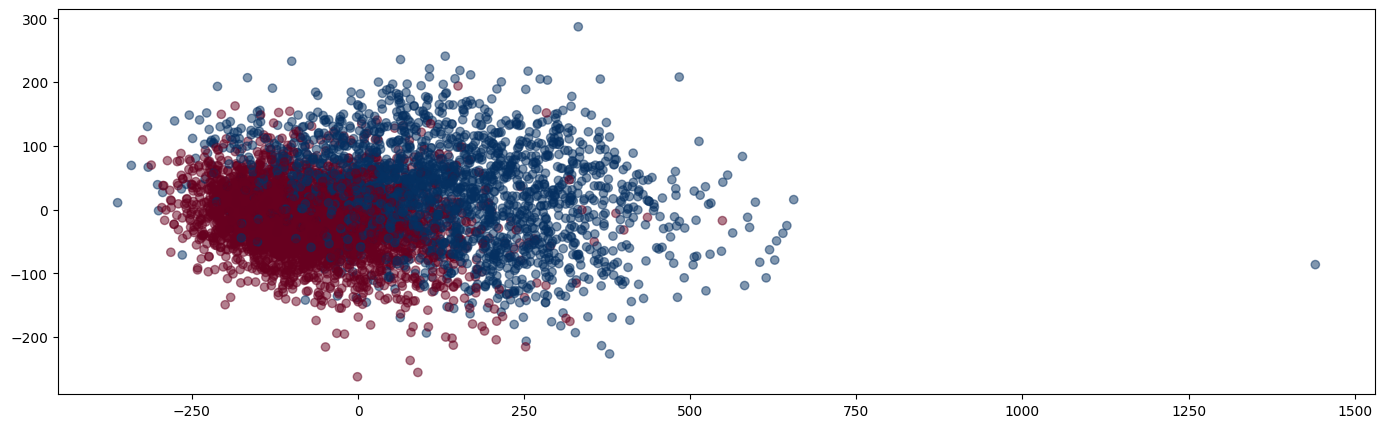

In [ ]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [ ]:
import os

def get_audio_path(audio_dir, track_id):
    """
    Constructs a file path for an audio file based on its track ID,
    considering the subdirectory structure of the FMA dataset.

    Parameters:
    - audio_dir: The base directory where audio files are stored (e.g., 'fma_small').
    - track_id: The ID of the track.

    Returns:
    - The file path to the audio file.
    """
    # Ensure track_id is a string, pad with zeros if necessary to make it 6 characters long
    track_id_str = str(track_id).zfill(6)
    # Subdirectory is the first three characters of the track_id
    subdir = track_id_str[:3]
    # Filename is the full track_id with '.mp3' extension
    filename = f"{track_id_str}.mp3"
    # Construct the full path
    return os.path.join(audio_dir, subdir, filename)

# Example usage
AUDIO_DIR = '/content/drive/MyDrive/MERT_Project/fma_small'  # Update this to your actual audio directory
track_id = 190
filename = get_audio_path(AUDIO_DIR, track_id)
print('File:', filename)
x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)


File: /content/drive/MyDrive/MERT_Project/fma_small/000/000190.mp3
Duration: 30.00s, 1323119 samples


In [ ]:
!pip install --upgrade librosa

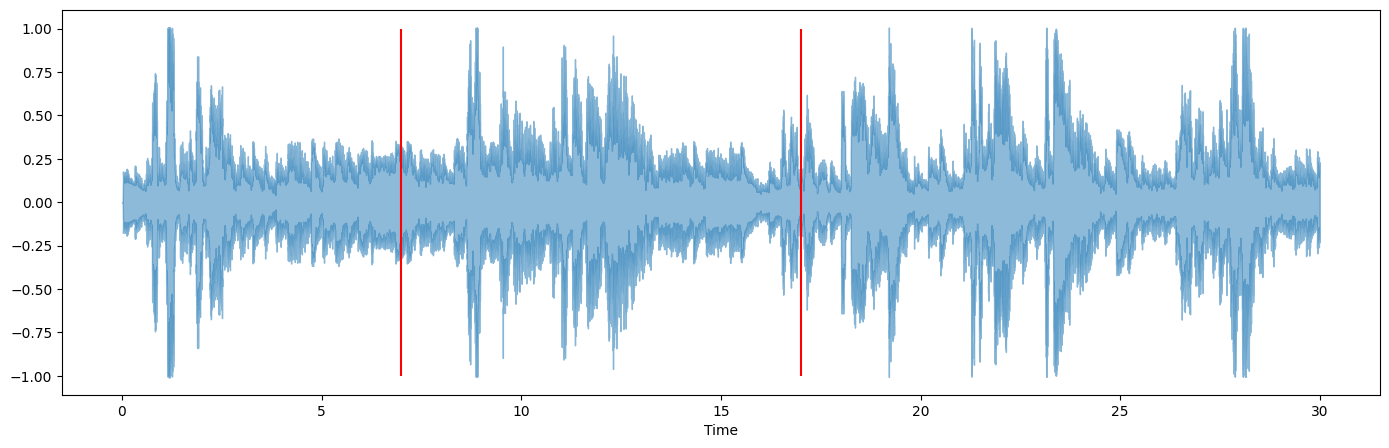

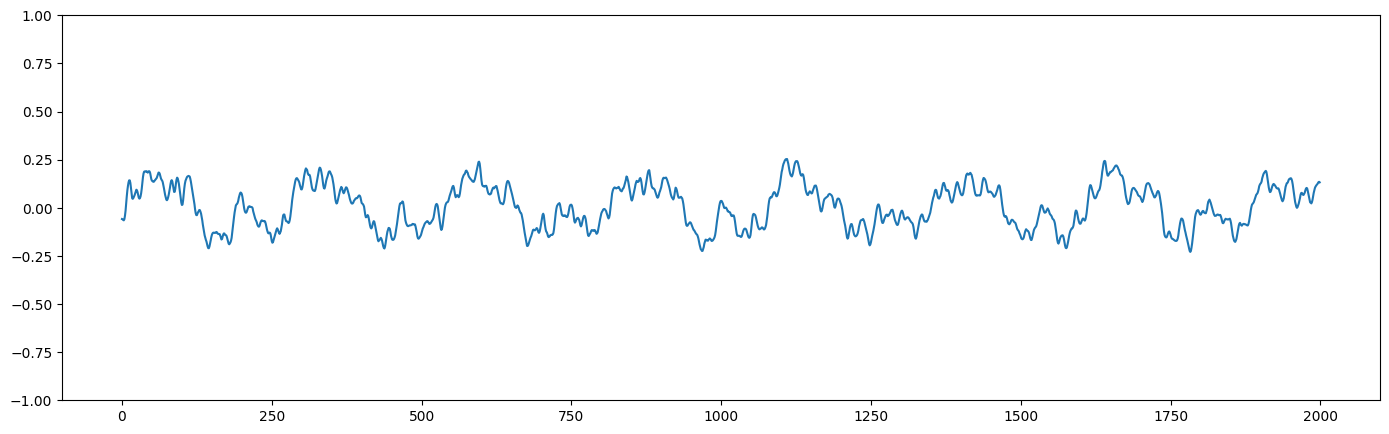

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

librosa.display.waveshow(x, sr=sr, alpha=0.5)
plt.vlines([start, end], ymin=-1, ymax=1, color='r')

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));


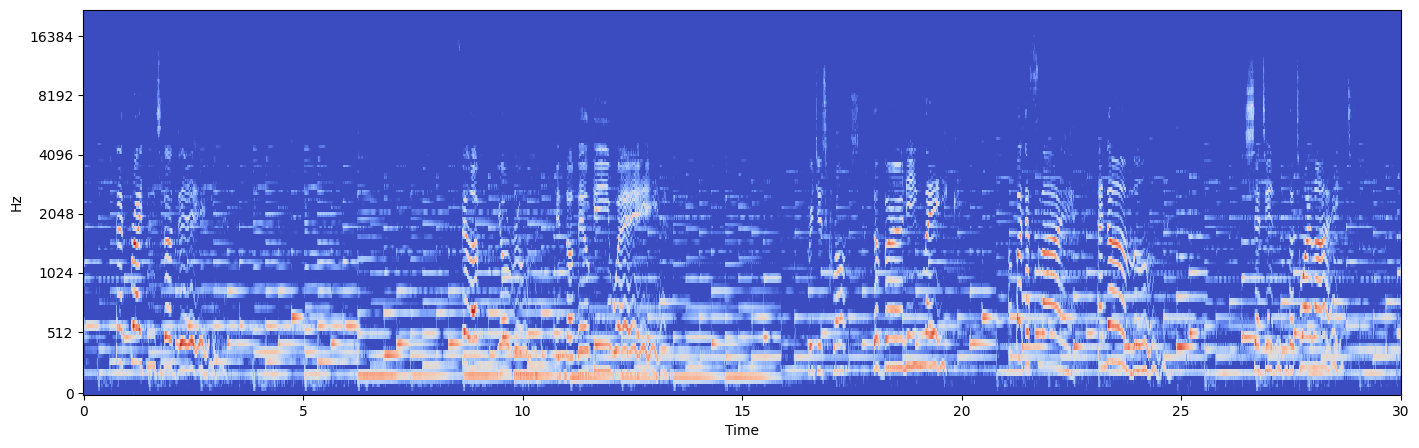

In [ ]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

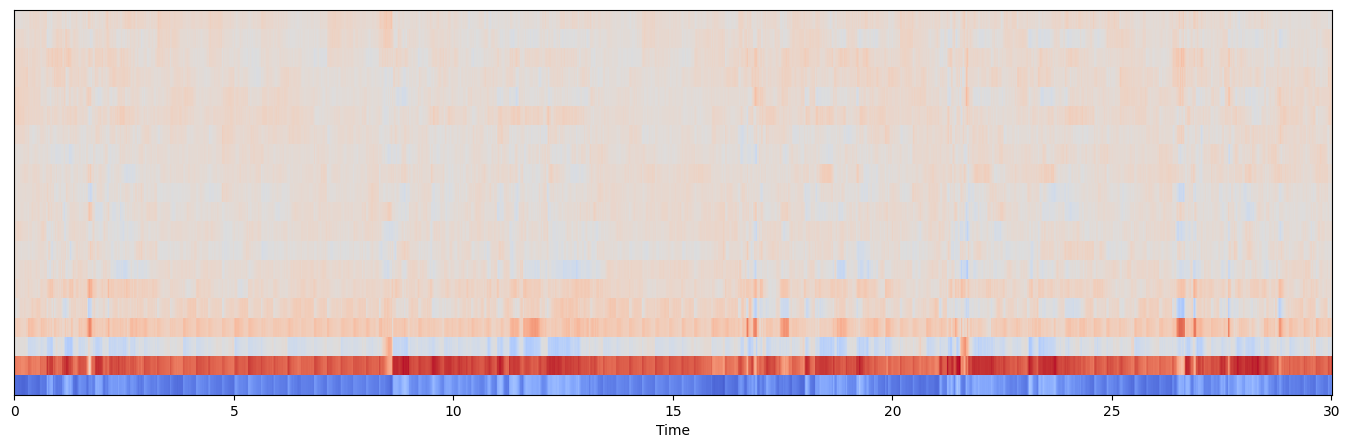

In [ ]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

In [ ]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

y_train = y_train.astype(str)
y_test = y_test.astype(str)

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))


84353 training examples, 11263 testing examples
140 features, 17 classes


In [ ]:
import os
import torchaudio
from torch.utils.data import Dataset, DataLoader

# Function to load MP3 audio data
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

# Directory containing MP3 audio files
audio_directory = '/content/drive/MyDrive/MERT_Project/fma_small'  # Replace with your directory path

# Collect all MP3 files in the directory and its subdirectories
audio_files = []
for root, _, files in os.walk(audio_directory):
    for file in files:
        if file.endswith('.mp3'):
            audio_files.append(os.path.join(root, file))

# Check if any files are found
if len(audio_files) == 0:
    raise ValueError(f"No MP3 files found in the directory {audio_directory}")

# Print the list of audio files found
print(f"Found {len(audio_files)} MP3 files in the directory.")
print("Audio files:", audio_files)

# Create a custom dataset
class CustomAudioDataset(Dataset):
    def __init__(self, audio_files):
        self.audio_files = audio_files

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = self.audio_files[idx]
        waveform, sample_rate = load_audio(file_path)
        return waveform, sample_rate

# Create DataLoader
dataset = CustomAudioDataset(audio_files)
print(f"Dataset contains {len(dataset)} samples.")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Verify DataLoader
for batch in dataloader:
    print("Batch loaded successfully")
    print(batch)
    break  # Just to check the first batch


Found 8000 MP3 files in the directory.
Audio files: ['/content/drive/MyDrive/MERT_Project/fma_small/000/000005.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000002.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000140.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000010.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000148.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000141.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000182.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000190.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000193.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000197.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000194.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000203.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000200.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/000204.mp3', '/content/drive/MyDrive/MERT_Project/fma_small/000/

RuntimeError: stack expects each tensor to be equal size, but got [2, 1323119] at entry 0 and [2, 1321967] at entry 1

In [ ]:
# Define model configuration
class MERTConfigClass:
    def __init__(self, num_layers=3, dropout_rate=0.5, learning_rate=1e-3):
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.embedding_dim = 768
        self.encoder_ffn_embed_dim = 3072
        self.encoder_attention_heads = 8
        self.dropout = 0.1
        self.attention_dropout = 0.1
        self.activation_dropout = 0.1
        self.activation_fn = "relu"
        self.layer_norm_first = False
        self.attention_relax = -1.0  # Set to a positive value to enable attention relaxation
        self.encoder_layers = 6  # Number of encoder layers
        self.deepnorm = False
        self.layer_type = "transformer"  # or "conformer"
        self.subln = True
        self.checkpoint_activations = False

# Initialize model with the configuration
args = MERTConfigClass()
model = TransformerEncoderExtend(args)


In [ ]:
import torch
from torch.optim import Adam

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Adjust according to your specific task
optimizer = Adam(model.parameters(), lr=args.learning_rate)

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for batch in dataloader:
        waveform_batch, sample_rate_batch = batch
        optimizer.zero_grad()
        # Process the waveform_batch as required by your model
        # Example: if your model expects a specific input shape, reshape or preprocess accordingly
        outputs, _ = model(waveform_batch)  # Adjust input according to model requirements
        # Assuming we have labels for a supervised task
        # labels = ...
        # loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')  # Replace loss with actual loss if using labels


In [ ]:
# Inference on new data
model.eval()
# Example new audio file for inference (replace with actual file path)
new_audio_file = 'path_to_new_audio_file.mp3'
new_waveform, new_sample_rate = load_audio(new_audio_file)

with torch.no_grad():
    # Process the new waveform as required by your model
    # Example: if your model expects a specific input shape, reshape or preprocess accordingly
    new_output, _ = model(new_waveform)  # Adjust input according to model requirements
    print(new_output)
